# Poisson Regression

Gaussian process models can be incredibly flexbile for modelling non-Gaussian data. One such example is in the case of count data $\mathbf{y}$, which can be modelled with a __Poisson model__ with a latent Gaussian process.
$$
\mathbf{y} \ | \ \mathbf{f} \sim \prod_{i=1}^{n} \frac{\lambda_i^{y_i}\exp\{-\lambda_i\}}{y_i!},
$$
where $\lambda_i=\exp(f_i)$ and $f_i$ is the latent Gaussian process.


┌ Info: Recompiling stale cache file /home/pindert2/.julia/compiled/v1.0/GaussianProcesses/izlaf.ji for GaussianProcesses [891a1506-143c-57d2-908e-e1f8e92e6de9]
└ @ Base loading.jl:1187
┌ Warning: Package GaussianProcesses does not have Zygote in its dependencies:
│ - If you have GaussianProcesses checked out for development and have
│   added Zygote as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GaussianProcesses
└ Loading Zygote into GaussianProcesses from project dependency, future warnings for GaussianProcesses are suppressed.


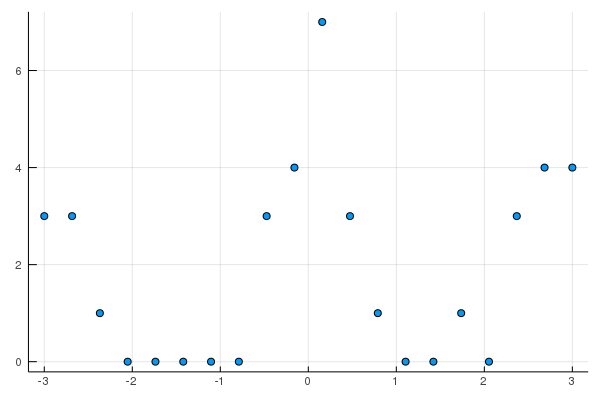

In [1]:
#Load the package
using GaussianProcesses, Random, Distributions, PDMats

#Simulate the data
Random.seed!(203617)
n = 20
X = collect(range(-3,stop=3,length=n));
f = 2*cos.(2*X);
Y = [rand(Poisson(exp.(f[i]))) for i in 1:n];

#Plot the data using the Plots.jl package with the GR backend
using Plots
gr()
scatter(X,Y,leg=false, fmt=:png)

In [2]:
#GP set-up
k = Matern(3/2,0.0,0.0)   # Matern 3/2 kernel
l = PoisLik()             # Poisson likelihood
gpmc = GP(X, vec(Y), MeanZero(), k, l)
gpvi = GP(X, vec(Y), MeanZero(), k, l)

GP Monte Carlo object:
  Dim = 1
  Number of observations = 20
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: Mat32Iso{Float64}, Params: [0.0, 0.0]
  Likelihood:
    Type: PoisLik, Params: Any[]
  Input observations = 
[-3.0 -2.68421 … 2.68421 3.0]
  Output observations = [3, 3, 1, 0, 0, 0, 0, 0, 3, 4, 7, 3, 1, 0, 0, 1, 0, 3, 4, 4]
  Log-posterior = -65.397

In [3]:
set_priors!(gpmc.kernel,[Normal(-2.0,4.0),Normal(-2.0,4.0)])
set_priors!(gpvi.kernel,[Normal(-2.0,4.0),Normal(-2.0,4.0)])
@time samples = mcmc(gpmc; nIter=10000);

Number of iterations = 10000, Thinning = 1, Burn-in = 1 
Step size = 0.100000, Average number of leapfrog steps = 10.029000 
Number of function calls: 100291
Acceptance rate: 0.801400 
  4.184331 seconds (24.17 M allocations: 2.024 GiB, 7.76% gc time)


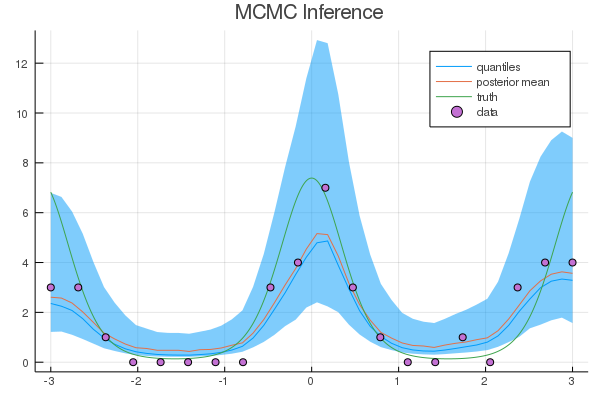

In [4]:
#Sample predicted values
xtest = range(minimum(gpmc.x),stop=maximum(gpmc.x),length=50);
ymean = [];
fsamples = Array{Float64}(undef,size(samples,2), length(xtest));
for i in 1:size(samples,2)
    set_params!(gpmc,samples[:,i])
    update_target!(gpmc)
    push!(ymean, predict_y(gpmc,xtest)[1])
    fsamples[i,:] = rand(gpmc, xtest)
end

#Predictive plots

q10 = [quantile(fsamples[:,i], 0.1) for i in 1:length(xtest)]
q50 = [quantile(fsamples[:,i], 0.5) for i in 1:length(xtest)]
q90 = [quantile(fsamples[:,i], 0.9) for i in 1:length(xtest)]
plot(xtest,exp.(q50),ribbon=(exp.(q10), exp.(q90)),leg=true, fmt=:png, label="quantiles", title = "MCMC Inference")
plot!(xtest,mean(ymean), label="posterior mean")
xx = range(-3,stop=3,length=1000);
f_xx = 2*cos.(2*xx);
plot!(xx, exp.(f_xx), label="truth")
scatter!(X,Y, label="data")

## Variational Inference

In [8]:
@time Q = vi(gpvi);

Number of iterations = 1, Thinning = 1, Burn-in = 1 
Step size = 0.100000, Average number of leapfrog steps = 14.000000 
Number of function calls: 15
Acceptance rate: 1.000000 
 12.287751 seconds (6.83 M allocations: 2.896 GiB, 4.46% gc time)


In [9]:
nsamps = 500
ymean = [];
visamples = Array{Float64}(undef, nsamps, size(xtest, 1))

for i in 1:nsamps
    visamples[i, :] = rand(gpvi, xtest, Q)
    push!(ymean, predict_y(gpvi, xtest)[1])
end

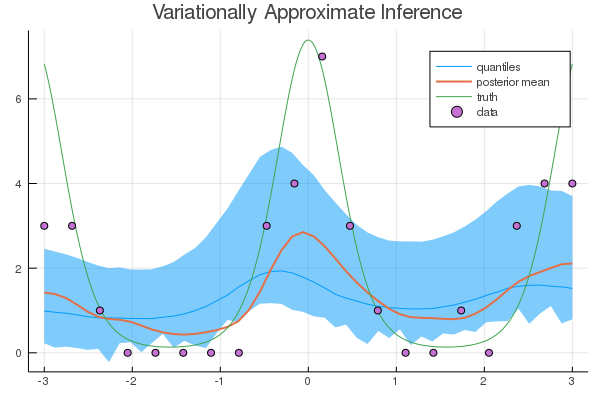

In [10]:
q10 = [quantile(visamples[i,:], 0.1) for i in 1:length(xtest)]
q50 = [quantile(visamples[:,i], 0.5) for i in 1:length(xtest)]
q90 = [quantile(visamples[:,i], 0.9) for i in 1:length(xtest)]
plot(xtest, exp.(q50), ribbon=(exp.(q10), exp.(q90)), leg=true, fmt=:png, label="quantiles", title="Variationally Approximate Inference")
plot!(xtest, mean(ymean), label="posterior mean", w=2)
xx = range(-3,stop=3,length=1000);
f_xx = 2*cos.(2*xx);
plot!(xx, exp.(f_xx), label="truth")
scatter!(X,Y, label="data")